In [26]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import BaseCrossValidator, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    r2_score,
    mean_squared_error,
    root_mean_squared_error
)

import warnings
warnings.filterwarnings('ignore')

In [27]:
sys.path.append(str(Path(__name__).resolve().parents[1]))

from preprocess.src import convert_data as cvd
from train.src import transform as tr

In [28]:
plt.style.use("dark_background")

In [29]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def SMAPE(y_test, y_pred):
	return np.mean((np.abs(y_test-y_pred))/(np.abs(y_test)+np.abs(y_pred)))*100


def add_lag(df:pd.DataFrame, target:str) -> pd.DataFrame:
    target_map = df[target].to_dict()

    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    
    return df


class LoadFeatures:
    TARGET = "Load"
    NUM_FEATURES = [
        "temperature",
        "humidity",
    ]
    CAT_FEATURES = [
        "is_hol",
    ]
    SCALE_FEATURES =[
        "temperature",
        "humidity",
        "hour_mean",
        "hour_std",
        "dayweek_hour_mean"
    ]
    DATE_FEATURES = ["Forecast_time"]

class LoadDataset(object):
    def __init__(self,
                 upstream_directory:str,
                 file_prefix: str,
                 file_name: str,
                 ):
        
        self.upstream_directory = upstream_directory
        self.file_prefix = file_prefix
        self.file_name = file_name
        
    def pandas_reader_dataset(self, target:str, time_column:str | None,) -> tuple[pd.DataFrame, pd.Series]:
        file_paths = str(
            Path() / self.upstream_directory / self.file_prefix / self.file_name
        )
        df = pd.read_csv(file_paths)
        if time_column is not None:
            df_ = self.transform_process(df, time_column, target)
            X = df_.drop(labels=[target], axis=1)
            y = df_[target]
            return X, y
        
        X = df.drop(labels=[target], axis=1)
        y = df[target]
        
        return X, y


    def transform_process(self, df:pd.DataFrame, time_column:str="Forecast_time", target:str="load"):
        tr.set_time_index(df,time_column)
        df = tr.create_time_features(df)
        df = tr.create_time_lag_features(df, target=target)
        hour_group_energy = tr.grouped_frame(df=df, group_col_list=['hour'], target_col_list=[target], method='mean')
        hour_group_energy_std = tr.grouped_frame(df=df, group_col_list=['hour'], target_col_list=[target], method='std')
        dayweek_hour_gruop_energy = tr.grouped_frame(df=df, group_col_list=["dayofweek", "hour"], target_col_list=[target], method="mean")
        df['hour_mean'] = df.apply(lambda x: hour_group_energy.loc[(hour_group_energy.hour == x['hour']), f'{target}_mean'].values[0], axis=1)
        df['hour_std'] = df.apply(lambda x: hour_group_energy_std.loc[(hour_group_energy_std.hour == x['hour']), f'{target}_std'].values[0], axis=1)
        df['dayweek_hour_mean'] = df.apply(lambda x: dayweek_hour_gruop_energy.loc[(dayweek_hour_gruop_energy.hour == x['hour']) & (
            dayweek_hour_gruop_energy.dayofweek == x['dayofweek']), f'{target}_mean'].values[0], axis=1)
        
        return df
        

def get_load_pipeline():
    
    numeric_features = LoadFeatures.SCALE_FEATURES
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
    )

    categorical_features = LoadFeatures.CAT_FEATURES
    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    return preprocessor

In [30]:
train_set = LoadDataset(upstream_directory="../data/preprocess/load/", file_prefix="train", file_name="train_dataset.csv")
test_set = LoadDataset(upstream_directory="../data/preprocess/load/", file_prefix="test", file_name="test_dataset.csv")

In [31]:
X_train, y_train = train_set.pandas_reader_dataset(target="Load", time_column="Forecast_time")
X_test, y_test = test_set.pandas_reader_dataset(target="Load", time_column="Forecast_time")

In [33]:
X_train.dropna().head()

,is_hol,temperature,humidity,hour,month,dayofweek,quarter,dayofyear,dayofmonth,lag1,lag2,lag3,lag4,hour_mean,hour_std,dayweek_hour_mean
Forecast_time,,,,,,,,,,,,,,,,
2016-01-08 00:00:00,0,1.2,50.4,0,1,4,1,8,8,3844.3125,3759.7350,3412.5300,2456.0425,3080.605933,702.127778,3378.147917
2016-01-08 01:00:00,0,0.5,52.6,1,1,4,1,8,8,4238.2600,4125.8625,3997.8850,2570.6650,3367.098216,819.007364,3739.010521
2016-01-08 02:00:00,0,-0.2,54.4,2,1,4,1,8,8,4280.5475,4202.6475,4062.4300,2389.2700,3378.929030,827.026445,3753.500260
2016-01-08 03:00:00,0,-0.6,56.4,3,1,4,1,8,8,4301.6900,4246.0475,4046.8475,2330.2925,3347.262784,820.299538,3721.784271
2016-01-08 04:00:00,0,-0.8,57.3,4,1,4,1,8,8,4293.3450,4178.1675,4041.8425,2244.0450,3358.089030,855.011091,3769.022292


In [18]:
print(f"Shape of X_train {X_train.shape} and y_train {y_train.shape}")
print(f"Shape of X_test {X_test.shape} and y_test {y_test.shape}")

Shape of X_train (8040, 16) and y_train (8040,)
Shape of X_test (744, 16) and y_test (744,)


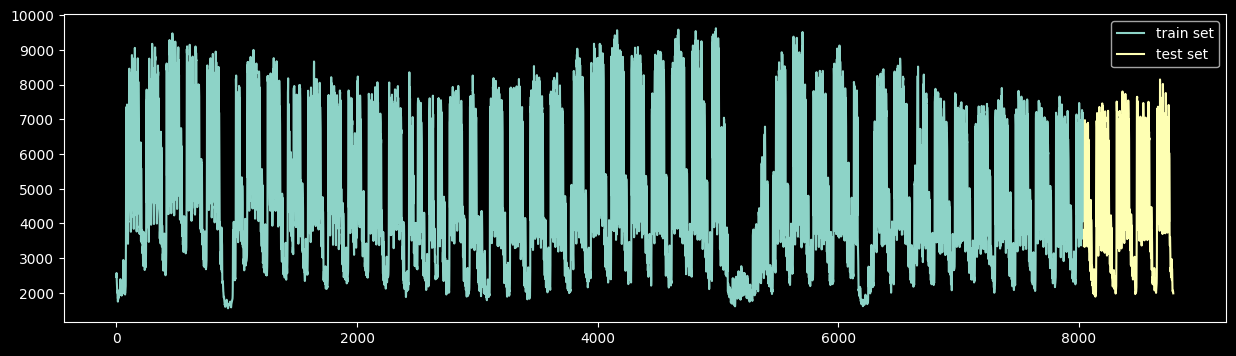

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

train_load = y_train
test_load = y_test

indices = list(range(train_load.shape[0] + test_load.shape[0]))

axes.plot(indices[:train_load.shape[0]], train_load, label="train set")
axes.plot(indices[train_load.shape[0]:], test_load, label="test set")
axes.legend()

In [20]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [21]:
models = []
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    model = RandomForestRegressor()
    input_pipeline = get_load_pipeline()
    model_ = Pipeline([("preprocessor", input_pipeline), ("model", model)]) 
    
    model_.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    models.append(model_)
    y_preds = model_.predict(X_train.iloc[test_index])

    # Evaluate predictions
    mae_score = mean_absolute_error(y_train.values[test_index], y_preds)
    mse_score = mean_squared_error(y_train.values[test_index], y_preds)
    rmse_score = RMSE(y_train.values[test_index], y_preds)
    mape_score = MAPE(y_train.values[test_index], y_preds)
    smape_score = SMAPE(y_train.values[test_index], y_preds)
    
    # Log model performance metrics to W&B
    print({"rmse": rmse_score, "mae": mae_score, "mse": mse_score, "mape":mape_score, "smape": smape_score})

{'rmse': 696.1457856556743, 'mae': 401.91639735126466, 'mse': 484618.954886156, 'mape': 10.345717978050855, 'smape': 4.705293430687315}
{'rmse': 644.4939048620446, 'mae': 388.455535740568, 'mse': 415372.39340432617, 'mape': 10.102227579143634, 'smape': 4.646472757280355}
{'rmse': 618.7700080160328, 'mae': 379.1706277467696, 'mse': 382876.32282016124, 'mape': 9.531535117113558, 'smape': 4.481295732877506}
{'rmse': 628.6959500159398, 'mae': 385.72709935686146, 'mse': 395258.5975664451, 'mape': 10.202307368821518, 'smape': 4.68589137678446}
{'rmse': 607.0342361725993, 'mae': 389.15255375940234, 'mse': 368490.5638856511, 'mape': 10.066454277358927, 'smape': 4.691611875425075}


In [34]:
import joblib

class Regressor(object):

    def __init__(
            self,
            model_directory:str,
            file_name:str,
            ):
        
        self.model = self.get_model(model_directory, file_name)

    def get_model(self, model_directory:str, file_name:str):
        model_file_direcotry = os.path.join(model_directory, file_name)
        model = joblib.load(model_file_direcotry)
        return model
    
    def predict(self, x):
        pred = self.model.predict(x)
        return pred

In [35]:
model_file_name = f"machine_load_0.joblib"
reg_mdl = Regressor(model_directory="../artifacts/model/load", file_name=model_file_name)

In [37]:
mdl_pred = reg_mdl.predict(X_test)

In [22]:
X_train_ = X_train.dropna()
y_train_ = y_train[X_train_.index]
model = RandomForestRegressor()
input_pipeline = get_load_pipeline()
model_ = Pipeline([("preprocessor", input_pipeline), ("model", model)]) 
model_.fit(X_train_, y_train_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['temperature', 'humidity',
                                                   'hour_mean', 'hour_std',
                                                   'dayweek_hour_mean']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['is_hol'])])),
                ('model', RandomForestRegressor())])

In [23]:
y_preds = []
for model in models:
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)
# y_preds = xgb_model.predict(X_test)
y_predictions = np.array(y_preds).mean(axis=0)

In [40]:

# Evaluate predictions
mae_score = mean_absolute_error(y_test, y_predictions)
mse_score = mean_squared_error(y_test, y_predictions)
rmse_score = RMSE(y_test, y_predictions)
mape_score = MAPE(y_test, y_predictions)
smape_score= SMAPE(y_test, y_predictions)

# Log model performance metrics to W&B
print({"rmse": rmse_score, "mae": mae_score, "mse": mse_score, "mape":mape_score, "smape": smape_score})


{'rmse': 464.54610488430035, 'mae': 348.13162428382617, 'mse': 215803.08356317537, 'mape': 8.915979418374588, 'smape': 4.199406292859279}


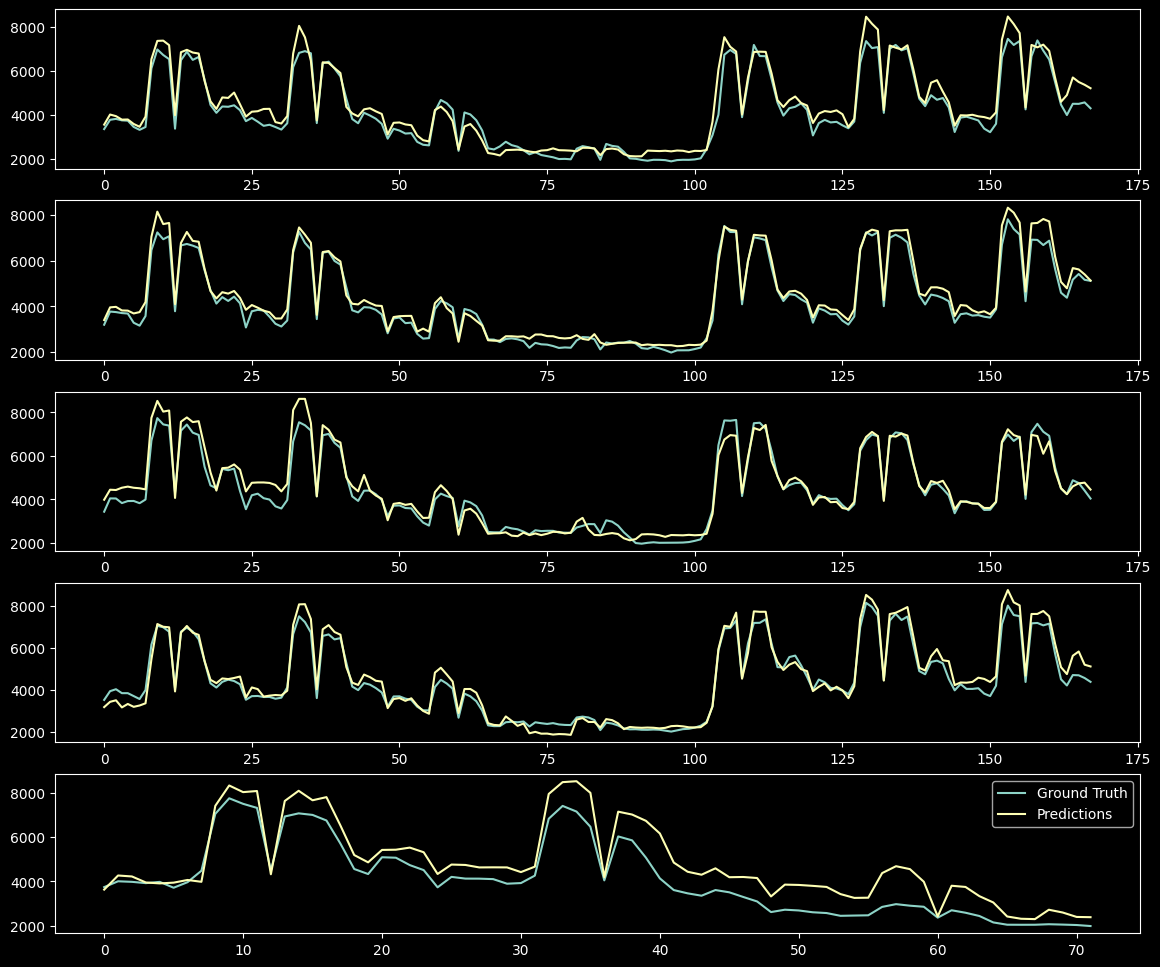

In [25]:
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

step = 168
ax_i = 0
for i in range(0, y_test.shape[0], step):
    if ax_i > 8:
        break
    axes[ax_i].plot(y_test[i:i+step].to_numpy(), label="Ground Truth")
    axes[ax_i].plot(y_predictions[i:i+step], label="Predictions")
    ax_i += 1
plt.legend()